In [91]:
import re
import json
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
from os import listdir
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

In [92]:
def build_tfidf(guidelines: list[str], pca_component=100):
    # Preprocess all documents (prior to building the vocabulary)
    corpus = []

    print(' - Proprocess and extract the corpus')
    for guideline in tqdm(guidelines):
        text = guideline["text"]

        # Replacing unconventional punctuation with spaces
        text = re.sub(r'[\(\)\[\]\,\-\;\.\!\?”“\"\']', ' ', text)
        text = re.sub(r'[\*+\_\#]+', ' ', text)
        text = re.sub(r'\s+', ' ', text)

        # Stemming is done by sklearn
        corpus.append(text)
    
    # Build the vocabulary matrix
    print(' - Vectorize the corpus')
    vectorizer = CountVectorizer(min_df=3) # Must be less that 80%
    counts = vectorizer.fit_transform(corpus).toarray()

    # Learn the IDF matrix
    print(' - Learn the IDF for each terms')
    transformer = TfidfTransformer(smooth_idf=True)
    transformer.fit(counts)

    # Build the TF-IDF matrix for each sample of the corpus
    print(' - Build the TF-IDF dense matrix')
    tfidf = transformer.transform(counts + 1).toarray() # Smoothing of the count

    # Running PCA on tf-idf matrix to select the important words
    pca = PCA(n_components=pca_component)
    pca.fit(tfidf)

    # Finally transform the tfidf matrix into a smaller collection
    compact_tfidf = pca.transform(tfidf)
    return compact_tfidf, pca, transformer, vectorizer

In [93]:
GUIDELINE_PATH = join('..', 'Guidelines', 'meditron-guidelines', 'processed')

In [94]:
# Retrieve all guidelines
print(' - Retrieving guidelines')
guidelines = []
for file in listdir(GUIDELINE_PATH):
    path = join(GUIDELINE_PATH, file)

    if path.endswith('.jsonl'):
        with open(path, 'r') as f:
            guidelines += [x for x in list(map(json.loads, f.readlines())) if 'title' in x]
# guidelines = guidelines[:5000]

 - Retrieving guidelines


In [ ]:
# Preprocess all texture (prior to building the vocabulary)
compact_idf, pca, transformer, vectorizer = build_tfidf(guidelines, pca_component=2)

 - Proprocess and extract the corpus


100%|██████████| 42336/42336 [00:14<00:00, 2872.33it/s]


 - Vectorize the corpus
 - Learn the IDF for each terms


: 

In [78]:
# Transform pca invert
X = np.eye(compact_idf.shape[1])
Y = pca.inverse_transform(X)

In [88]:
sort = np.argsort(-np.abs(Y), axis=1)
sort = sort[:, :10]

for i in range(2):
    print('============================== FEATURE {} =============================='.format(i))
    M = sort[i, :]
    yy = Y[i, M]
    names = vectorizer.get_feature_names_out()[M]
    print('\n'.join('{:<30}: {}'.format(name, p) for name, p in zip(names, yy)))

============================== FEATURE 0 ==============================
mg                            : 0.20471821274924654
iv                            : 0.1420138184284753
kg                            : 0.12283327842322293
day                           : 0.12094937554799991
infections                    : 0.0970942058690086
vaccine                       : 0.09664462542649324
orally                        : 0.09652423018086576
every                         : 0.09011815890789793
hours                         : 0.0856110420058199
treatment                     : 0.08444272352692175
============================== FEATURE 1 ==============================
mg                            : -0.4578849138558035
vaccine                       : 0.40062505186608993
orally                        : -0.21176427055488445
day                           : -0.17143953518929672
influenza                     : 0.14509068980821965
iv                            : -0.14064743778327235
vaccination             

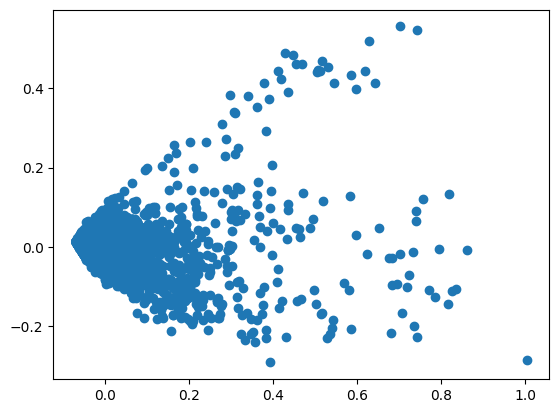

In [87]:
A, B = compact_idf.T
plt.scatter(A, B)